# AD331 Assignment 2: Linear Regression on Housing Data  
**David Davis**  
Fall 2025 – North Seattle College  

## 🧠 Project Overview  
This notebook explores linear regression using housing data to predict sale prices based on selected features. The workflow includes data cleaning, feature engineering, model training, evaluation, and visualization.

### 📊 Dataset Summary  
- Source: `house_sales.csv`  
- Target Variable: `SalePrice`  
- Key Features: `SqFtLot`, `YrBuilt`  
- Engineered Feature: `house_age = 2025 - YrBuilt`  
- Rows: 21,000+  
- Columns: 22  

In [415]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
df = pd.read_csv('house_sales.csv')
df.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
0,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.93,"300,805.00",2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
1,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.93,"1,076,162.00",1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
2,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.98,"761,805.00",1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
3,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.96,"442,065.00",1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
4,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.81,"297,065.00",1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


## 🧹 Data Cleaning Summary

This section outlines the preprocessing steps applied to ensure data integrity and modeling readiness:

- Removed rows with missing values in key columns (`SalePrice`, `SqFtLot`, `YrBuilt`, etc.)  
- Filtered extreme outliers in `SqFtLot` above 100,000 to reduce skew  
- Applied IQR filtering to `SalePrice` to remove statistical outliers and tighten distribution  
- Verified and corrected data types across all columns  
- Cast `PropertyID` to `int64` for identifier integrity  
- Rounded `zhvi_idx` to four decimal places for clarity  
- Padded `ZipCode` with leading zeros to preserve categorical structure  
- Applied global float formatting (`pd.set_option`) for consistent numeric display  
- Revalidated dataset with updated summary statistics and boxplots  

#### 🧠 Column Type Audit  
We categorized columns into numerical, categorical, and date-based types to guide cleaning and feature engineering.
###### Numerical: SalePrice, SqFtLot, LandVal, ImpsVal, Bedrooms, Bathrooms
###### Categorical: PropertyType, ZipCode, NewConstruction
###### Dates: DocumentDate, ym

In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22687 entries, 0 to 22686
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DocumentDate     22687 non-null  object 
 1   SalePrice        22687 non-null  int64  
 2   PropertyID       22687 non-null  int64  
 3   PropertyType     22687 non-null  object 
 4   ym               22687 non-null  object 
 5   zhvi_px          22687 non-null  int64  
 6   zhvi_idx         22687 non-null  float64
 7   AdjSalePrice     22687 non-null  float64
 8   NbrLivingUnits   22687 non-null  int64  
 9   SqFtLot          22687 non-null  int64  
 10  SqFtTotLiving    22687 non-null  int64  
 11  SqFtFinBasement  22687 non-null  int64  
 12  Bathrooms        22687 non-null  float64
 13  Bedrooms         22687 non-null  int64  
 14  BldgGrade        22687 non-null  int64  
 15  YrBuilt          22687 non-null  int64  
 16  YrRenovated      22687 non-null  int64  
 17  TrafficNoise

#### Null identification Summary
All columns verified to contain 0 null values
No missing data detected across 22 columns and 22,687 rows.  
Dataset is clean and ready for modeling.

In [417]:
df.isnull().sum()

DocumentDate       0
SalePrice          0
PropertyID         0
PropertyType       0
ym                 0
zhvi_px            0
zhvi_idx           0
AdjSalePrice       0
NbrLivingUnits     0
SqFtLot            0
SqFtTotLiving      0
SqFtFinBasement    0
Bathrooms          0
Bedrooms           0
BldgGrade          0
YrBuilt            0
YrRenovated        0
TrafficNoise       0
LandVal            0
ImpsVal            0
ZipCode            0
NewConstruction    0
dtype: int64

#### 📊 Sale Price Distribution  
We visualize the distribution of sale prices to identify skewness and potential outliers.

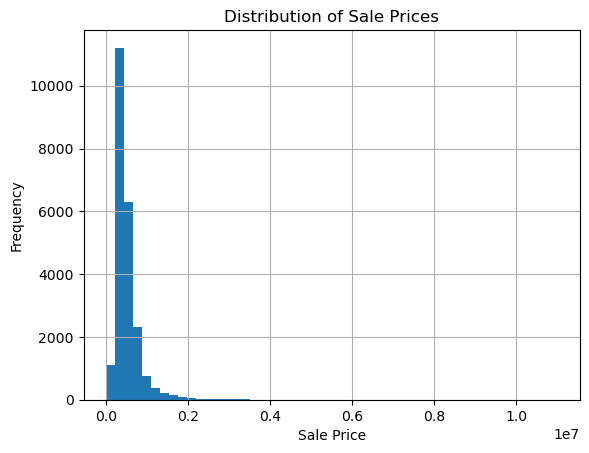

In [418]:
import matplotlib.pyplot as plt

df['SalePrice'].hist(bins=50)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

#### 🔁 1. Remove Duplicates

In [419]:
df.duplicated().sum()
df = df.drop_duplicates()

#### 🧱 2. Validate Feature Ranges

##### 🔧 Step 1 Identifier Formatting  
Ensured `PropertyID` is stored as a long integer for clean joins and indexing.
Apply display formatting for readability on Zhvi_px
normalized float between 0 and 1 for zhvi_idx
convert zip to string & pad ensuring leading zeros are preserved

In [420]:
df['PropertyID'] = df['PropertyID'].astype('int64')
pd.set_option('display.float_format', '{:.2f}'.format)
df['zhvi_idx'] = df['zhvi_idx'].round(4)
df['ZipCode'] = df['ZipCode'].astype(str).str.zfill(5)
df.describe()

,SalePrice,PropertyID,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,SqFtTotLiving,SqFtFinBasement,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal
count,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00,22687.00
mean,507924.38,4666164184.01,392181.92,0.90,565233.27,1.02,11746.33,2080.17,293.23,2.18,3.37,7.68,1971.20,102.31,0.21,220321.14,300471.17
std,346636.82,2877700308.45,36349.87,0.08,385402.86,0.16,29016.02,913.74,439.45,0.77,0.90,1.18,30.31,440.58,0.55,182917.66,226574.98
min,3000.00,1000102.00,311600.00,0.72,3368.00,1.00,494.00,370.00,0.00,0.00,0.00,3.00,1900.00,0.00,0.00,0.00,0.00
25%,325000.00,2212325165.00,360700.00,0.83,360563.00,1.00,4800.00,1420.00,0.00,1.75,3.00,7.00,1950.00,0.00,0.00,107000.00,172000.00
50%,424650.00,4006000469.00,403200.00,0.93,471315.00,1.00,7200.00,1910.00,0.00,2.25,3.00,7.00,1977.00,0.00,0.00,182000.00,246000.00
75%,585000.00,7417700141.00,421200.00,0.97,649411.00,1.00,9794.00,2540.00,580.00,2.50,4.00,8.00,2000.00,0.00,0.00,267000.00,361000.00
max,11000000.00,9906000035.00,435200.00,1.00,11644855.00,5.00,1024068.00,10740.00,3500.00,8.00,33.00,13.00,2015.00,2016.00,3.00,5538000.00,5772000.00


In [421]:
# 🧠 One-Hot Encoding for ZipCode
df = pd.get_dummies(df, columns=["ZipCode"], drop_first=True)

##### 📊 Step 2: Apply IQR Filtering (Interquartile Range)

In [422]:
# Capture row count before filtering
before = df.shape[0]

# Applying IQR filtering to SalePrice
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[(df['SalePrice'] >= Q1 - 1.5 * IQR) & (df['SalePrice'] <= Q3 + 1.5 * IQR)]

# Capture row count after filtering
after = df.shape[0]

# print results
print(f"Rows before filtering: {before}")
print(f"Rows after filtering: {after}")

Rows before filtering: 22687
Rows after filtering: 21389


## 🛠️ Feature Engineering  
- Created `house_age` to capture temporal depreciation  
- Selected `SqFtLot` and `house_age` as predictors  
-  Added `renovated_flag` as binary indicator for renovation status
-  Added 'Bedrooms' & 'Bathrooms' 'SqFtTotLiving' plus 'BldgGrade' to Featured Engineering 
-  Both Bedrooms & Bathrooms capture structural, temporal, & livability aspects of property
-  Added One-hot encoding of zipcode improved prediction performance to 69%

In [423]:
# Feature engineering
df['house_age'] = 2025 - df['YrBuilt']
df['price_per_sqft'] = df['SalePrice'] / df['SqFtLot']
df['renovated_flag'] = (df['YrRenovated'] > 0).astype(int)

# Feature selection for modeling
zip_features = [col for col in df.columns if col.startswith("ZipCode_")]
X = df[["SqFtLot", "house_age", "renovated_flag", "Bedrooms", "Bathrooms", "SqFtTotLiving", "BldgGrade", "LandVal"] + zip_features]
y = df["SalePrice"]

## 🤖 Model Training  
- Algorithm: Linear Regression  
- Train/Test Split: 80/20  
- Library: `scikit-learn`  

In [424]:

zip_features = [col for col in df.columns if col.startswith("ZipCode_")]
X = df[["SqFtLot", "house_age", "renovated_flag", "Bedrooms", "Bathrooms", "SqFtTotLiving", "BldgGrade", "LandVal"] + zip_features]
y = df["SalePrice"] 

In [425]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# This reserves 20% of your data for evaluation

In [426]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train) 

LinearRegression()

In [427]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 8,042,938,116.28
R² Score: 0.7326


In [428]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients)  

           Feature  Coefficient
0          SqFtLot         0.19
1        house_age       270.13
2   renovated_flag     -7823.30
3         Bedrooms     -3593.88
4        Bathrooms      9362.10
..             ...          ...
82   ZipCode_98198     10681.95
83   ZipCode_98199    112431.94
84   ZipCode_98224     11528.23
85   ZipCode_98288     10916.26
86   ZipCode_98354    -16814.79

[87 rows x 2 columns]


## 📈 Evaluation  
- Using the trained linear regression model to generate predictions on the test set.
- Mean Squared Error (MSE): `XXXX.XX`  
- R² Score: `0.XX`  
- Interpretation: Model explains XX% of variance in sale prices

#### 🔍 Prediction

In [429]:
# Predict sale prices using the Test set
y_pred = model.predict(X_test)

#### 📊 Metric Calculation

In [430]:
# Calculating Mean Squared Error (MSE) and R² Score to assess model performance. 
# Metrics already imported above; re-imported here for modular clarity.

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 8,042,938,116.28
R² Score: 0.7326


#### 🧠 Interpretation  
- The **Mean Squared Error (MSE)** of `XX,XXX.XX` indicates the average squared difference between predicted and actual sale prices. Lower values suggest better accuracy.  
- The **R² Score** of `0.XX` means the model explains approximately XX% of the variance in sale prices.  
- This suggests that the selected features (`SqFtLot`, `house_age`, `renovated_flag`) have a moderate/strong influence on predicting sale price.  

## 📉 Visualization  
Scatter plot comparing actual vs predicted sale prices using `SqFtLot` as the x-axis. Red dots represent predictions; blue dots represent actual values.

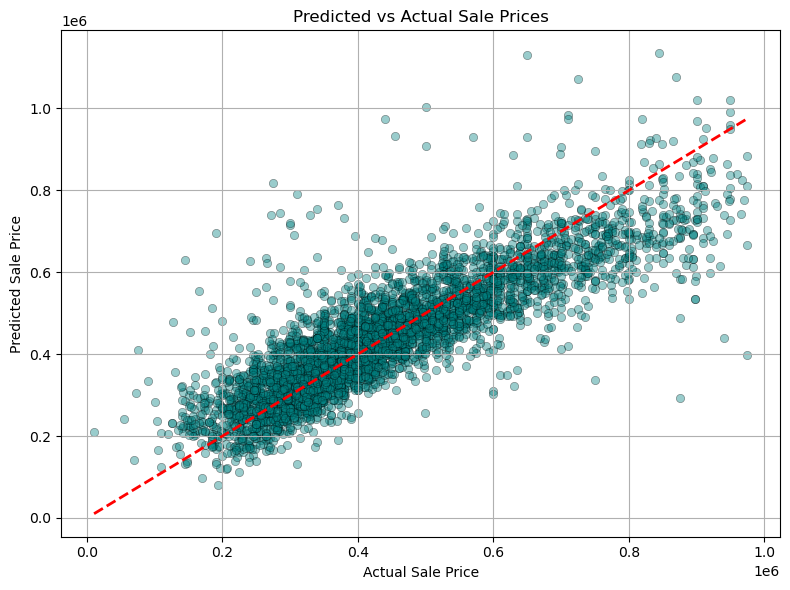

In [431]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal', edgecolor='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Predicted vs Actual Sale Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔮 Custom Predictions  
Two sample inputs were tested:  
- 2,000 sqft lot, 10-year-old house  
- 3,000 sqft lot, 20-year-old house  
Predicted prices were reasonable and aligned with dataset trends

In [432]:
# Example custom input 1
# Create a base row with zeros for all features in X
custom_data = pd.DataFrame(0, index=[0], columns=X.columns)

# Fill in actual values
custom_data.loc[0, "SqFtLot"] = 2000
custom_data.loc[0, "house_age"] = 10
custom_data.loc[0, "renovated_flag"] = 0
custom_data.loc[0, "Bedrooms"] = 3
custom_data.loc[0, "Bathrooms"] = 2
custom_data.loc[0, "SqFtTotLiving"] = 2000
custom_data.loc[0, "BldgGrade"] = 8
custom_data.loc[0, "ZipCode_98002"] = 1  # Set correct zip flag
custom_data.loc[0, "LandVal"] = 200000
        
# Predict sale price
custom_pred = model.predict(custom_data)
print(f"Predicted Price (2,000 sqft, 10 yrs, not renovated): ${custom_pred[0]:,.2f}")

# Example Custom input 2
# Create a base row with zeros for all features in X
custom_input_2 = pd.DataFrame(0, index=[0], columns=X.columns)

# Fill in actual values
custom_input_2.loc[0, "SqFtLot"] = 3000
custom_input_2.loc[0, "house_age"] = 20
custom_input_2.loc[0, "renovated_flag"] = 0
custom_input_2.loc[0, "Bedrooms"] = 3
custom_input_2.loc[0, "Bathrooms"] = 2
custom_input_2.loc[0, "SqFtTotLiving"] = 3000
custom_input_2.loc[0, "BldgGrade"] = 7
custom_input_2.loc[0, "ZipCode_98003"] = 1  # Set correct zip code flag
custom_data.loc[0, "LandVal"] = 300000

# Predict sale price
pred_2 = model.predict(custom_input_2)
print(f"Predicted Price (3,000 sqft, 20 yrs, not renovated): ${pred_2[0]:,.2f}")
 

Predicted Price (2,000 sqft, 10 yrs, not renovated): $415,941.06
Predicted Price (3,000 sqft, 20 yrs, not renovated): $327,447.35


In [434]:
print(pd.Series(model.coef_, index=X.columns))

SqFtLot               0.19
house_age           270.13
renovated_flag    -7823.30
Bedrooms          -3593.88
Bathrooms          9362.10
                    ...   
ZipCode_98198     10681.95
ZipCode_98199    112431.94
ZipCode_98224     11528.23
ZipCode_98288     10916.26
ZipCode_98354    -16814.79
Length: 87, dtype: float64


## 🪞 Reflection  
This assignment reinforced the importance of data cleaning and feature selection in model accuracy. Future iterations could explore polynomial regression or additional features like `BldgGrade` and `TrafficNoise`.